Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully u

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


Epoch [1/10], Loss: 0.7613
Epoch [2/10], Loss: 0.5409
Epoch [3/10], Loss: 0.4258
Epoch [4/10], Loss: 0.4429
Epoch [5/10], Loss: 0.3073
Epoch [6/10], Loss: 0.3439
Epoch [7/10], Loss: 0.3845
Epoch [8/10], Loss: 0.4032
Epoch [9/10], Loss: 0.3040
Epoch [10/10], Loss: 0.2478

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.72      0.72      0.72        18

    accuracy                           0.71        35
   macro avg       0.71      0.71      0.71        35
weighted avg       0.71      0.71      0.71        35


Confusion Matrix:
 [[12  5]
 [ 5 13]]
Prediction: No Tumour (99.19% confidence)


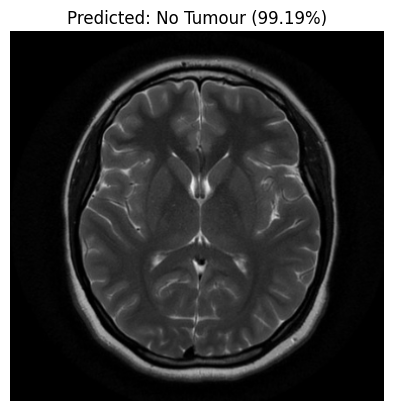

In [1]:
# Mount Google Drive to access files stored there
from google.colab import drive
drive.mount('/content/drive')

# Set the directory containing the brain tumour dataset
data_dir = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset'

# Install required libraries
!pip install torch torchvision scikit-learn matplotlib

# Import Python libraries for data handling, modelling, and evaluation
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Import PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Define data transformations: resizing, augmenting, normalising
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Custom dataset class to load MRI images and labels
class BrainMRIDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load all image file paths and assign a label based on the folder name ('no' = 0, 'yes' = 1)
image_paths, labels = [], []
for label, category in enumerate(['no', 'yes']):
    folder = os.path.join(data_dir, category)
    for file in os.listdir(folder):
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(folder, file))
            labels.append(label)

# Split data into training and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Create dataset objects using custom class
train_dataset = BrainMRIDataset(train_paths, train_labels, transform)
test_dataset = BrainMRIDataset(test_paths, test_labels, transform)

# Create DataLoaders to feed data into the model in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Load a ResNet18 model that has been pretrained on ImageNet
model = models.resnet18(pretrained=True)

# Freeze base layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

model = model.to(device)

# Define loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Train the model for a number of epochs
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


# Now test the model on unseen data
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels)


# Show detailed classification metrics and the confusion matrix
print("\nClassification Report:\n", classification_report(all_targets, all_preds))
print("\nConfusion Matrix:\n", confusion_matrix(all_targets, all_preds))

# Function to predict and display a single image from file
def predict_image(image_path, model, transform):
    model.eval()

    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    transformed = transform(image).unsqueeze(0).to(device)

    # Run the model
    with torch.no_grad():
        output = model(transformed)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence = probabilities[0].max().item() * 100
        _, predicted = torch.max(output, 1)

    # Map the prediction
    classes = ['No Tumour', 'Tumour']
    prediction = classes[predicted.item()]
    print(f"Prediction: {prediction} ({confidence:.2f}% confidence)")

    # Show the image
    plt.imshow(image)
    plt.title(f"Predicted: {prediction} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()


# Run the prediction function on a new uploaded image
predict_image('/content/drive/MyDrive/Colab Notebooks/scantest4.png', model, transform)

# Optional: display a few predictions from the test set for visual inspection
def show_predictions(n=5):
    model.eval()
    shown = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)
            for i in range(images.size(0)):
                if shown >= n:
                    return
                img = images[i].permute(1, 2, 0) * 0.5 + 0.5
                plt.imshow(img.numpy())
                plt.title(f"True: {'Tumour' if labels[i] else 'No Tumour'}, Pred: {'Tumour' if preds[i] else 'No Tumour'}")
                plt.axis('off')
                plt.show()
                shown += 1

# show_predictions()

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model.pth')
